In [6]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


In [10]:
import sys
import os

# Calculate the project root (three levels up from this notebook)
project_root = os.path.ab spath(os.path.join(os.getcwd(), "../../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [11]:
from src.house_price_predictor.model.estimators import ScikitLearnEstimator

In [12]:

# Set MLflow tracking URI (adjust port if needed)
mlflow.set_tracking_uri(uri="http://localhost:8080")
mlflow.set_experiment("house-price-prediction")


<Experiment: artifact_location='mlflow-artifacts:/521658517913579349', creation_time=1747526868052, experiment_id='521658517913579349', last_update_time=1747526868052, lifecycle_stage='active', name='house-price-prediction', tags={}>

In [18]:
# Load processed train and test data
train_df = pd.read_parquet("../../../data/staged/train.parquet")
test_df = pd.read_parquet("../../../data/staged/test.parquet")

In [19]:


# Separate features and target
target = "price"
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

models = [
    LinearRegression(),
    RandomForestRegressor(random_state=42),
    XGBRegressor(random_state=42)
]


In [20]:

for model in models:
    with mlflow.start_run(run_name=model.__class__.__name__):
        estimator = ScikitLearnEstimator(model)
        estimator.train(X_train, y_train)
        y_pred = estimator.predict(X_test)
        metrics = estimator.evaluate(y_test, y_pred)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, "model")
        print(f"Logged metrics for {estimator.estimator_name}")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")

Entrenando modelo de Scikit-learn: ScikitLearn - LinearRegression


2025/05/17 19:46:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Evaluando el modelo: ScikitLearn - LinearRegression


2025/05/17 19:46:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/17 19:46:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged metrics for ScikitLearn - LinearRegression
r2: 0.6244
rmse: 1377904.0964
mse: 1898619698762.5422
mae: 1016906.9544
max_error: 4921809.3875
mape: 0.2206
🏃 View run LinearRegression at: http://localhost:8080/#/experiments/521658517913579349/runs/1516e16287c8421a9896d17bb3f023e2
🧪 View experiment at: http://localhost:8080/#/experiments/521658517913579349
Entrenando modelo de Scikit-learn: ScikitLearn - RandomForestRegressor


2025/05/17 19:46:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Evaluando el modelo: ScikitLearn - RandomForestRegressor


2025/05/17 19:46:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/17 19:46:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged metrics for ScikitLearn - RandomForestRegressor
r2: 0.5941
rmse: 1432352.2747
mse: 2051633038700.7087
mae: 1034991.8416
max_error: 5656140.0000
mape: 0.2221
🏃 View run RandomForestRegressor at: http://localhost:8080/#/experiments/521658517913579349/runs/1f584f1d50e24b76bf11892cbbb8b533
🧪 View experiment at: http://localhost:8080/#/experiments/521658517913579349
Entrenando modelo de Scikit-learn: ScikitLearn - XGBRegressor
Evaluando el modelo: ScikitLearn - XGBRegressor


2025/05/17 19:46:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/17 19:46:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged metrics for ScikitLearn - XGBRegressor
r2: 0.5598
rmse: 1491623.5814
mse: 2224940908544.0000
mae: 1069891.8750
max_error: 6923362.5000
mape: 0.2305
🏃 View run XGBRegressor at: http://localhost:8080/#/experiments/521658517913579349/runs/08846257c4624a3aa7e05fc082b4e753
🧪 View experiment at: http://localhost:8080/#/experiments/521658517913579349


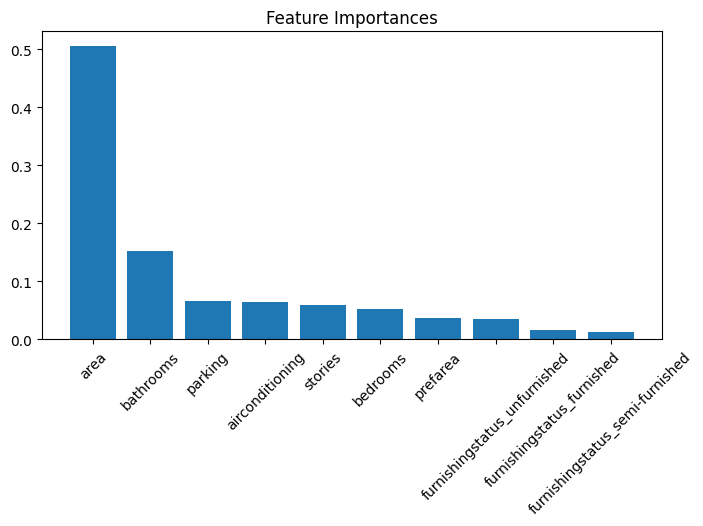

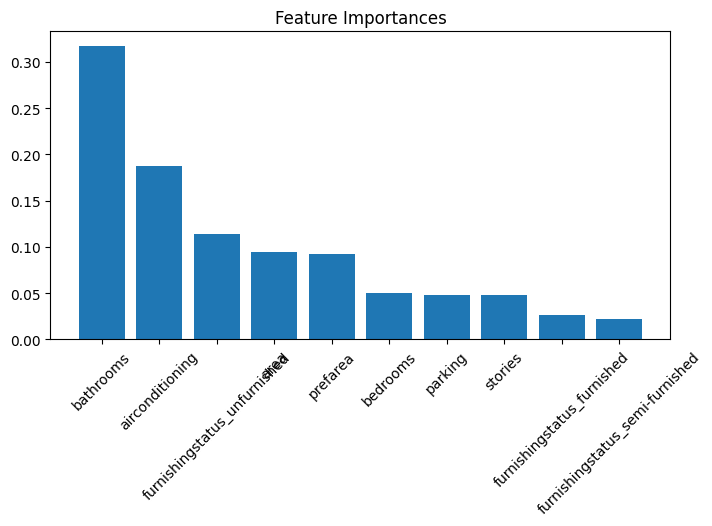

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already fit your model, e.g.:
# rf = RandomForestRegressor().fit(X_train, y_train)
# or
# xgb = XGBRegressor().fit(X_train, y_train)

def plot_feature_importances(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8,4))
    plt.title("Feature Importances")
    plt.bar(range(top_n), importances[indices], align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45)
    plt.show()

# Example usage:
plot_feature_importances(models[1], X_train.columns)
plot_feature_importances(models[2], X_train.columns)